# Choosing a place for a veg eatery in New York, Los Angeles or Chicago

### Data sources:
* Dataset 'US vegetarian restaurants', available from [Kaggle](https://www.kaggle.com/parkerservello/veg-restaurants)
* Dataset 'Insightful & Vast USA Statistics' available from [Kaggle](https://www.kaggle.com/goldenoakresearch/us-acs-mortgage-equity-loans-rent-statistics), as well.
    * Missing values were chcked manually using [Mapszipcode](http://www.mapszipcode.com/california/woodland%20hills/91364/) site.
* Google databases (through *Google API* quries)
* Foursquare databases (API queries as well)
* OpenStreetMap map and textual data (through *Folium* and  *Nominatim* libraries, accordingly)


### 1. Load and clean Kaggle dataset

In [2]:
import pandas as pd
import numpy as np
import requests
import re
import warnings
warnings.filterwarnings('ignore')
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 100)

In [439]:
# API keys and stuff:
g_key = ''
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'

In [23]:
data_raw = pd.DataFrame()
ch_size = 1000
for chunk in pd.read_csv('veg.csv', chunksize=ch_size):
    data_raw = data_raw.append(chunk[chunk['city'] == 'New York'])
    data_raw = data_raw.append(chunk[chunk['city'] == 'Los Angeles'])
    data_raw = data_raw.append(chunk[chunk['city'] == 'Chicago'])

From the original data set we need the following data:
- 'name' -- the name of the place
- 'city' -- the city of its placement 
- 'lat', 'long' -- its coordinates  

The remaining data (place id, rating, number of reviews, price level (0-4), place categories) will be taken from Google databases
The postal code will be received based on coordinates -- much easier than tidying up the **posalCode** column.

In [25]:
data_raw.city.value_counts(dropna=False)

New York       553
Los Angeles    303
Chicago        264
Name: city, dtype: int64

In [27]:
data_raw.shape

(1120, 29)

In [248]:
data = data_raw[['name', 'city', 'lat', 'long' ]].reset_index(drop=True)

In [249]:
# first off, let's remove the rows that have no values in all three columns 'name', 'lat', 'long',
# there's nothing we can do here:
data = data[~pd.isnull(data[['name', 'lat', 'long']]).all(axis=1)].reset_index(drop=True)

In [250]:
data.shape

(1085, 4)

In [251]:
# let's find out the places with no coordinates:
data[pd.isnull(data[['lat', 'long']]).all(axis=1)].sort_values(by='name').shape

(355, 4)

As we see, there are many dublicates. That's ok, because different places can carry a common name of the network. At last, we will evaluate separate places, not the netowrks. 


In [252]:
# let's save the results above to a temporary df, removing the data from the original df,
# then remove duplicates from the original data (those are the entries with the same coordinates)
# and then add processed temporary df data to the original df;

tmp = data[pd.isnull(data[['lat', 'long']]).all(axis=1)] # saving the datapoints that have no coordinates
tmp = tmp.drop_duplicates().reset_index(drop=True) 
data = data[~pd.isnull(data[['lat', 'long']]).all(axis=1)]
data = data.drop_duplicates(subset=['lat', 'long']).reset_index(drop=True)

Let's get rid of empty coordinates' columns as well:

In [253]:
tmp.drop(['lat', 'long'], axis=1, inplace=True)

As we see, the *name* column contains entries with "unusual" (e.g. diamond) symbols. Let's filter those entries out and fix them:

In [254]:
pattern = '^[ -~]*$' # finding only ASCII chars, all the table from space to tilda
mask = tmp.name.str.contains(pattern)
mask.value_counts(dropna=False)
mask = mask.map({np.nan:False, True:True, False:False})

In [255]:
tmp[~mask]

,name,city
15,Jack’s Stir Brew Coffee,New York
20,Jack���s Stir Brew Coffee,New York
135,Jivamuktea Café,New York
180,Brü Chicago,Chicago
184,Delicious Café,Chicago
189,Café Blossom,New York
201,Buddha Bodai ���������������,New York
210,Nish Nūsh,New York


In [256]:
tmp.drop(20, inplace=True) # there's already a caffe with the same name (row 15), but properly formatted
tmp.iloc[201,0] = 'Buddha Bodai'

Let's check out *name* column of the main df as well:

In [257]:
pattern = '^[ -~]*$' # finding only ASCII chars, all the table from space to tilda
mask = data.name.str.contains(pattern)
mask.value_counts(dropna=False)
mask = mask.map({np.nan:False, True:True, False:False})

In [258]:
data[~mask]

,name,city,lat,long
14,NaN,New York,40.755911,-73.980066
37,NaN,New York,40.729426,-73.999668
63,NaN,Los Angeles,33.943510,-118.408130
66,NaN,Los Angeles,34.101750,-118.300940
131,NaN,Chicago,41.941500,-87.669930
161,NaN,Los Angeles,34.047940,-118.261200
162,NaN,Los Angeles,34.033104,-118.442880
204,NaN,Los Angeles,34.056408,-118.249916
223,NaN,New York,40.725410,-73.986880
226,NaN,New York,40.743200,-73.979960


In [259]:
data[data['name'].str.contains('closed')]

,name,city,lat,long
16,Vegetarian Paradise 3 (closed),New York,40.714804,-73.999021
20,Basil &berry (closed),Los Angeles,34.055157,-118.387072
81,S'mac (closed),New York,40.723387,-73.988413
170,Seed Bistro (closed),Los Angeles,34.046734,-118.464485
361,Dojo East (closed),New York,40.728813,-73.988782
363,Blanche's Organic Cafe--uptown (closed),New York,40.690530,-73.924962
374,Drew's Eatery (closed),Chicago,41.961431,-87.684235
409,Ellyssa Restaurant (reported closed),New York,40.762584,-73.989412
458,Helianthus (closed),New York,40.679154,-73.919625


Let's delete the rows of closed restaurants and the points with no names. The manual check of the latter ones show that there are no (vegetarian) restaurants at those coordinates.

In [260]:
data.drop(data[data['name'].isnull()].index, inplace=True)

In [261]:
data.drop(data[data['name'].str.contains('closed') == True].index, inplace=True)

In [263]:
tmp.reset_index(drop=True, inplace=True)

In [264]:
tmp.head()

,name,city
0,David Josephs Catering,New York
1,Freefoods Nyc,New York
2,Peacefood Cafe,New York
3,Juice Press At Equinox Bryant Park,New York
4,Veggie Grill,Los Angeles


Let's create a new df to add to discovered data based on appropriate Google queries taken from tmp df:

In [285]:
discovered = pd.DataFrame()

In [286]:
for i in range(len(tmp)):
    url = 'https://maps.googleapis.com/maps/api/place/textsearch/json?query={}&fields=place_id,geometry,name,types,rating,user_ratings_total,price_level,permanently_closed&key={}'.format(
        tmp.name[i]+', '+tmp.city[i], g_key)
    response = requests.get(url).json()
    try:
        _ = json_normalize(response['results'])[['name', 'place_id', 'geometry.location.lat', 'geometry.location.lng', 'types', 'rating',  'user_ratings_total']]
    except Exception as e:
        print('Exception at tmp row {}: '.format(i))
        print(e.args)
        continue
    discovered = discovered.append(_, sort=False)


Exception at tmp row 7: 
("None of [Index(['name', 'place_id', 'geometry.location.lat', 'geometry.location.lng',\n       'types', 'rating', 'user_ratings_total'],\n      dtype='object')] are in the [columns]",)
Exception at tmp row 18: 
("None of [Index(['name', 'place_id', 'geometry.location.lat', 'geometry.location.lng',\n       'types', 'rating', 'user_ratings_total'],\n      dtype='object')] are in the [columns]",)
Exception at tmp row 34: 
("None of [Index(['name', 'place_id', 'geometry.location.lat', 'geometry.location.lng',\n       'types', 'rating', 'user_ratings_total'],\n      dtype='object')] are in the [columns]",)
Exception at tmp row 68: 
("None of [Index(['name', 'place_id', 'geometry.location.lat', 'geometry.location.lng',\n       'types', 'rating', 'user_ratings_total'],\n      dtype='object')] are in the [columns]",)
Exception at tmp row 77: 
("None of [Index(['name', 'place_id', 'geometry.location.lat', 'geometry.location.lng',\n       'types', 'rating', 'user_rating

In [291]:
discovered.sample(10)

,name,place_id,geometry.location.lat,geometry.location.lng,types,rating,user_ratings_total
9,Franchia Vegan Cafe,ChIJwwO-oAdZwokRQ4RYQeCkjF4,40.747584,-73.981301,"[cafe, store, restaurant, point_of_interest, food, establishment]",4.5,764
8,Chobani SoHo,ChIJs0qy041ZwokRPsZa7P2mcPw,40.725807,-74.001134,"[cafe, store, restaurant, point_of_interest, food, establishment]",4.5,593
0,The Punchbowl,ChIJgxA28q7AwoAR1E67WpHPvuU,34.103752,-118.291242,"[point_of_interest, food, establishment]",4.7,69
0,NY Dosas,ChIJrwM59flZwokRZQLT207ntHU,40.730783,-73.998844,"[restaurant, point_of_interest, food, establishment]",4.7,21
9,sweetgreen,ChIJ6TuWSJJZwokRIvcVZcp-Q7U,40.729992,-74.002434,"[restaurant, point_of_interest, food, establishment]",4.1,192
4,The Veggie Grill,ChIJtXoLnjG5woARtlc4y_h6UoU,34.073673,-118.360619,"[restaurant, point_of_interest, food, establishment]",4.5,415
8,Halal Indian Food and Gyro Truck,ChIJ2xIETRlawokRzfTInXY8dUo,40.715278,-74.011275,"[restaurant, point_of_interest, food, establishment]",4.3,10
13,Natalee,ChIJF0z9kC66woARWu0sxPZvsos,34.022662,-118.400655,"[restaurant, point_of_interest, food, establishment]",4.3,793
3,Jamba Juice,ChIJt0zsbne7woARHVc2O0VI_7E,34.047425,-118.443394,"[restaurant, point_of_interest, food, establishment]",3.8,64
4,Granny's Kitchen Southern Style Soul Food,ChIJV4ml11nIwoARL-o_PXjkIjg,33.993219,-118.256118,"[restaurant, point_of_interest, food, establishment]",4.3,270


In [309]:
print(tmp.shape[0], discovered.shape[0])

240 913


As we can see,  the resulting table contains about 4 times more entries compared to the source. That's because many restaurants are a part of a chain under the same name. 

In [307]:
discovered.reset_index(drop=True, inplace=True)

In [308]:
# it's always a good idea to save received data (even intermediate one) into a file:
discovered.to_csv('discovered.csv', index=False)

Let's returt to the main data file. We need to update it with the same data, as it could be seen in the *discovered* dataframe. As soon as we need just update the data, not discovering the places, its resulting length should remain the same, unless the presence of erroneous data; in this case, .

In [321]:
data.reset_index(drop=True, inplace=True) # we need to rebuild the index after deleting some data.

In [323]:
new_data = pd.DataFrame()

In [324]:
for i in range(len(data)):
    url = 'https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input={}&inputtype=textquery&type=restaurant&fields=name,place_id,geometry,types,rating,user_ratings_total&key={}&locationbias=circle:10@{},{}'.format(
        data.name[i], g_key, data.lat[i],data.long[i])
    try:
        response = requests.get(url).json()
    except Exception as e:
        print('Exception in RESPONSE, data row {}: '.format(i))
        print(e.args)
        break
    try:
        _ = json_normalize(response['candidates'])[['name', 'place_id', 'geometry.location.lat', 'geometry.location.lng', 'types', 'rating',  'user_ratings_total']]
    except Exception as e:
        print('Exception in data at row {}: '.format(i))
        print(e.args)
        continue
    new_data = new_data.append(_, sort=False)

Exception in data at row 13: 
("None of [Index(['name', 'place_id', 'geometry.location.lat', 'geometry.location.lng',\n       'types', 'rating', 'user_ratings_total'],\n      dtype='object')] are in the [columns]",)
Exception in data at row 15: 
("['rating', 'user_ratings_total'] not in index",)
Exception in data at row 25: 
("None of [Index(['name', 'place_id', 'geometry.location.lat', 'geometry.location.lng',\n       'types', 'rating', 'user_ratings_total'],\n      dtype='object')] are in the [columns]",)
Exception in data at row 40: 
("None of [Index(['name', 'place_id', 'geometry.location.lat', 'geometry.location.lng',\n       'types', 'rating', 'user_ratings_total'],\n      dtype='object')] are in the [columns]",)
Exception in data at row 62: 
("['rating', 'user_ratings_total'] not in index",)
Exception in data at row 124: 
("None of [Index(['name', 'place_id', 'geometry.location.lat', 'geometry.location.lng',\n       'types', 'rating', 'user_ratings_total'],\n      dtype='object'

**The exeptions above were received by two reasons:**
1. The `ratings` and `ratings_total` fields don't exist in return query -- this place is not a restaurant (anymore), otherwise they should've been returned with n/a rating (if the place was not evaluated yet)
2. All of the columns are not existant -- the query is empty

In [334]:
new_data.reset_index(drop=True, inplace=True)
new_data.to_csv('new_data.csv', index=False)

In [381]:
final_raw = pd.DataFrame()
final_raw = final_raw.append(new_data, ignore_index=True, sort=False)
final_raw = final_raw.append(discovered, ignore_index=True, sort=False)

In [382]:
final_raw.reset_index(drop=True, inplace=True)

As soon as `drop_duplicates` method won't work, if any column contains lists, we should exclude this column (in our case, the column **types**). But in our case, we have a column `place_id`, which values are unique for each place, so we'll just use it as a parameter:

In [383]:
final_raw.drop_duplicates(subset='place_id', inplace=True)

In [384]:
final_raw.shape

(1169, 7)

In [385]:
final_raw.rename(columns={'geometry.location.lat':'lat', 'geometry.location.lng':'lng'}, inplace=True)

In [386]:
final_raw.to_csv('vegrest.csv', index=False)

In [387]:
final_raw.head()

,name,place_id,lat,lng,types,rating,user_ratings_total
0,Pongal,ChIJE5Ex1AlZwokRvFG2E-cZIVM,40.742453,-73.982883,"[restaurant, food, point_of_interest, establishment]",4.0,432
1,Quantum Leap,ChIJ2f4cvJFZwokRRDFRDaXTFUA,40.729202,-73.998851,"[restaurant, point_of_interest, food, establishment]",4.5,303
2,Green Symphony,ChIJizZBb71ZwokRmeogtgN0CTM,40.737949,-73.996643,"[restaurant, point_of_interest, food, establishment]",4.3,33
3,Verizon,ChIJqbaPqBL2wokR20L79Q45iBM,40.808606,-73.948218,"[store, point_of_interest, establishment]",3.4,100
4,Liquiteria,ChIJJ3Yyib5ZwokRaHQSm-HzAIY,40.740454,-74.001721,"[point_of_interest, food, establishment]",4.0,149


For further analysis we don't need the `place_id` column, so let's delete it:

In [400]:
final_raw.drop(columns='place_id', axis=1, inplace=True)

In [403]:
final_raw.sample(5)

,name,lat,lng,types,rating,user_ratings_total
930,Tender Greens,34.048416,-118.254361,"[restaurant, point_of_interest, food, establishment]",4.3,302
566,HaiSous Vietnamese Kitchen,41.857857,-87.653560,"[restaurant, point_of_interest, food, establishment]",4.4,396
1048,Birdsong's Veggietaria,34.041675,-118.255511,"[point_of_interest, establishment]",0.0,0
887,Naturewell Vegan Juice & Smoothies,34.091251,-118.279547,"[store, health, restaurant, point_of_interest, food, establishment]",4.2,48
901,Lots of Love Childcare,41.744221,-87.655782,"[point_of_interest, establishment]",1.0,1


So far so good. Let's take a closer look at the `types` column. A place where food is being served shold have a tag *food* in the column types. Let's find out, which columns do not contain this tag (e.g. the place is closed by the time I make this project) and remove these entries.

In [582]:
# despite we have saved the data into a file, it's always a good idea to leave the original data intact.
df = final_raw.copy()

In [583]:
df[df.types.apply(lambda x: False if 'food' in x else True)].shape[0]

128

In [584]:
df.drop(df[df.types.apply(lambda x: False if 'food' in x else True)].index, inplace=True)

In [586]:
df.sample(5)

,name,lat,lng,types,rating,user_ratings_total
757,Vegan Love,40.728521,-73.983256,"[restaurant, point_of_interest, food, establishment]",4.4,21
559,Orbit Steak Fish & Chicken,41.729260,-87.604861,"[restaurant, food, point_of_interest, establishment]",3.7,13
290,Peeled Snacks,40.668391,-73.994561,"[store, health, point_of_interest, food, establishment]",3.7,3
1385,Le Midi,40.735079,-73.993155,"[bar, restaurant, point_of_interest, food, establishment]",4.3,208
672,sweetgreen,40.778012,-73.954892,"[restaurant, point_of_interest, food, establishment]",4.3,216


In [587]:
df.reset_index(drop=True, inplace=True) # resetting index after deleting rows

We need to know, what venues are around our places nearby (in radius of 30 m). It is not important to know the specific type of a venue (e.g. whether it is Italian or Japanese restaurant), but we need to find out, how many competitors are there (food places) compared to the total number of venues. By the way, the difference between the total number of venues and the number of food places is the number of potential *traffic generators* (bus stops, stores, offices, banks etc.). For now we need two additional columns into our df: the total number of venues nearby and the number of competitors nearby (within the area of ~ 3 $km^2$ )

In [1008]:
food_places = [
    'Restaurant', 'BBQ', 'Bakery', 'Coffee Shop', 'Pizza', 'Cheese', 'Steakhouse',
    'Pub', 'Fried Chicken', 'Food Court', 'Food Stand', 'Food Truck', 'Friterie', 'Dessert', 'Bodega',
    'Creperie', 'Bistro', 'Cafe', 'Café', 'Breakfast', 'Bagel', 'Buffet', 'Bubble Tea Shop', 
    'Diner', 'Donut', 'Gastropub', 'Salad', 'Sandwich', 'Tea Room', 'Truck Shop', 'Wings Joint']
for ind in df.index:
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, df.lat[ind], df.lng[ind], VERSION, '*', 30, 50)
    try:
        response = requests.get(url).json()
    except Exception as e:
        print('\n\nException while sending GET at df row {}'.format(ind))
        print(e.args)
        break
    try:
        df.at[ind,'venues_total'] = len(response['response']['venues'])
    except Exception as e:
        print("Parsing exception at row {}:\n{}".format(ind, e.args))
        break
    try:
        categories = []
        for i in response['response']['venues']:
            for j in i['categories']:
                categories.append(j['name'])
        competitors = 0
        for i in categories:
            for j in food_places:
                if j in i:
                    competitors += 1
        df.at[ind,'venues_comp'] = competitors
    except:
        df.at[ind,'venues_comp'] = None
        continue

In [720]:
df.head()

,name,lat,lng,types,rating,user_ratings_total,venues_total,venues_comp
0,Pongal,40.742453,-73.982883,"[restaurant, food, point_of_interest, establishment]",4.0,432,50.0,9.0
1,Quantum Leap,40.729202,-73.998851,"[restaurant, point_of_interest, food, establishment]",4.5,303,42.0,8.0
2,Green Symphony,40.737949,-73.996643,"[restaurant, point_of_interest, food, establishment]",4.3,33,50.0,9.0
3,Liquiteria,40.740454,-74.001721,"[point_of_interest, food, establishment]",4.0,149,49.0,9.0
4,Taste of Bhakti,40.723776,-73.988494,"[restaurant, point_of_interest, food, establishment]",4.7,21,47.0,9.0


In [271]:
# the queries were time and quota consuming, so yet another backup:
df.reset_index(drop=True, inplace=True)
df.to_csv('df_interm.csv', index=False)

Within the radius of 100 meters around the place roughly the half of  them have exactly 50 venues around. That is because of the limitations of  free foursquare account. So, in order to overcome the limitation, or at least to minimize its influence, we have to reduce the radius by more than a half (to 30 meters). 

The results (see the figure below) show that there's still a significant number of 'fifties' (> 21%), while all the remainig values are distributed in the range of 0-4%.
Instead of furter decreasing the radius of observations, I'll analyze these 21% of cases separately later.

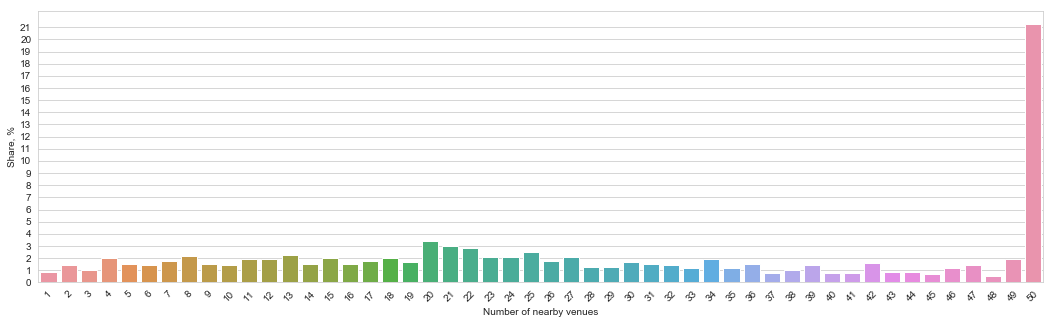

In [8]:
plt.figure(figsize=(18,5))
tmpdat = df.venues_total.value_counts(normalize=True).to_frame().reset_index()
tmpdat['venues_total'] = tmpdat['venues_total'].apply(lambda x: round(x*100, 1))
# tmpdat = df.venues_total.value_counts(normalize=True).apply(lambda x: x*100)
sns.barplot(y = tmpdat.venues_total, x=tmpdat['index'].astype(int))
plt.xticks(rotation=45)
plt.xlabel('Number of nearby venues')
plt.yticks(range(22))
plt.ylabel('Share, %')
plt.show()

One of the important factors for a restaurant to be at least accessable (especially in the US) is the parking places nearby. Let's find out how many of them are there around every place in our df:

In [1155]:
for ind in df.index:
    url='http://nominatim.openstreetmap.org/search?format=json&q=parking+near+{},{}&addressdetails=0&limit=100'.format(
    df.lat[ind], df.lng[ind])
    try:
        response = requests.get(url).json()
    except Exception as e:
        print('\n\nException while sending GET at df row {}'.format(ind))
        print(e.args)
        break
    try:
        df.at[ind,'parking'] = len(response)
    except Exception as e:
        print("Parsing exception at row {}:\n{}".format(ind, e.args))
        break

Let's add cities, boroughs/neighborhoods and postcodes to the table. The postcodes are needed for additional data to be merged to the table. At the same time, it will be an additional check for the coordinates. If there's something wrong we need to check the suspicious results (those marked with the tag `checkme` in the field `borough`) later separately.

In [153]:
for i in df.index:
    url = 'https://nominatim.openstreetmap.org/reverse?format=json&lat={}&lon={}&zoom=20&addressdetails=1'.format(
    df.at[i, 'lat'], df.at[i, 'lng'])
    try:
        response = requests.get(url).json()
    except Exception as e:
        print('Error while sending GET at line {}: '.format(i))
        print(e.args)
        break
    try:
        df.at[i,'zip'] = response['address']['postcode']
    except:
        df.at[i,'borough'] = 'checkme'
    try:
        response['address']['city'] # trying to parse the city name...
    except:                         # ...but the coordinates lead somewhere into the field; blast you, Google!
        df.at[i,'city'] = None
        df.at[i,'borough'] = 'checkme' 
        continue
    if response['address']['city'] == 'NYC':
        df.at[i,'city'] = response['address']['city']
        try:
            df.at[i,'borough'] = response['address']['city_district']
        except:
            df.at[i,'borough'] = 'checkme'
    elif (response['address']['city'] == 'LA') | (response['address']['city'] == 'Chicago'):
        df.at[i,'city'] = response['address']['city']
        try:
            df.at[i,'borough'] = response['address']['suburb']
        except:
            df.at[i,'borough'] = 'checkme'
    else:
        df.at[i,'city'] = response['address']['city']
        df.at[i,'borough'] = 'checkme'

In [494]:
df.city.value_counts(dropna=False)

NYC        443
Chicago    248
LA         234
Name: city, dtype: int64

In [540]:
df[df.borough == 'checkme'].sample(10)

,name,lat,lng,types,rating,user_ratings_total,venues_total,venues_comp,parking,zip,city,borough
360,Gallery Cafe,41.910660,-87.672448,"['cafe', 'store', 'point_of_interest', 'food', 'establishment']",4.5,142,28.0,3.0,33.0,60302,Chicago,checkme
508,Raja Sweets & Fast Food,40.748996,-73.892882,"['restaurant', 'point_of_interest', 'food', 'establishment']",4.4,195,22.0,12.0,30.0,11372,NYC,checkme
378,Orbit Steak Fish & Chicken,41.729260,-87.604861,"['restaurant', 'food', 'point_of_interest', 'establishment']",3.7,13,2.0,1.0,29.0,60619,Chicago,checkme
500,Freshii,41.898249,-87.622822,"['restaurant', 'point_of_interest', 'food', 'establishment']",3.9,65,30.0,7.0,50.0,nan,Chicago,checkme
208,Papa Romeo's Pizza,41.960658,-87.727582,"['meal_delivery', 'meal_takeaway', 'restaurant', 'point_of_interest', 'food', 'establishment']",2.6,41,17.0,2.0,33.0,60641,Chicago,checkme
789,Chipotle Mexican Grill,41.799764,-87.588060,"['restaurant', 'point_of_interest', 'food', 'establishment']",3.8,444,36.0,7.0,37.0,60615,Chicago,checkme
598,Chicago Raw,41.894743,-87.630099,"['restaurant', 'point_of_interest', 'food', 'establishment']",4.5,158,35.0,3.0,44.0,60610,Chicago,checkme
576,Olive Garden Italian Restaurant,40.734004,-73.868731,"['bar', 'meal_takeaway', 'restaurant', 'point_of_interest', 'food', 'establishment']",4.0,2125,11.0,1.0,49.0,11373,NYC,checkme
414,Jamba Juice,41.882044,-87.640479,"['point_of_interest', 'food', 'establishment']",3.9,45,34.0,17.0,39.0,60606,Chicago,checkme
501,Freshii,41.881043,-87.641478,"['store', 'restaurant', 'point_of_interest', 'food', 'establishment']",3.2,27,43.0,9.0,38.0,60661,Chicago,checkme


It looks like the postal codes are mostly there, but we need to check them anyway:

In [541]:
df.zip.dtype # should be 5-digit int, but 

dtype('O')

In [507]:
pattern = '[0-9]{5}' # finding only 5-digit numbers
mask = df.zip.str.contains(pattern)
mask = mask.map({np.nan:False, True:True, False:False})

Seems like the most of the postal codes are still there in a form of extended 9-digit code or with a state two-letter prefix; we need to exrtact them at first: 

In [532]:
ind_nonnum = df[~df.zip.apply(lambda x: str(x).isnumeric())]['zip'].index

In [531]:
for i in ind_nonnum:
    try:
        df.at[i, 'zip'] = re.findall(pattern, str(df.at[i, 'zip']))[0].strip()
    except:
        continue

In [553]:
df.iloc[ind_nonnum, :]['zip'].value_counts(dropna=False)

nan    75
Name: zip, dtype: int64

Looks like non-numeric values in `zip` fieald are all `nan`s. Let's try to put it through *nominatim* one more time, but changing (empirically) the `zoom` value to `18`:

In [554]:
tmp = pd.DataFrame()
for i in ind_nonnum:
    url = 'https://nominatim.openstreetmap.org/reverse?format=json&lat={}&lon={}&zoom=18&addressdetails=1'.format(
    df.at[i, 'lat'], df.at[i, 'lng'])
    try:
        response = requests.get(url).json()
    except Exception as e:
        print('Error while sending GET at line {}: '.format(i))
        print(e.args)
        break
    try:
        tmp.at[i,'zip'] = response['address']['postcode']
    except:
        tmp.at[i,'borough'] = 'checkme'

In [558]:
tmp.sample(10)

,zip,borough
89,90026-2106,NaN
506,60601,NaN
110,90046-4101,NaN
509,NaN,checkme
391,10011,NaN
137,10038,NaN
666,NaN,checkme
276,CA 90024,NaN
515,NaN,checkme
140,90041-1238,NaN


Looks like most of the `nan`s are now filled with postal codes, but still we need to deal with remaining `nan`s somehow. But first, let's format the received zip codes:

In [559]:
for i in tmp.index:
    try:
        df.at[i, 'zip'] = re.findall(pattern, str(tmp.at[i, 'zip']))[0].strip()
    except:
        continue

In [564]:
# let's create a list of nan indexes once again:
ind_nonnum = df[~df.zip.apply(lambda x: str(x).isnumeric())]['zip'].index

In [565]:
ind_nonnum

Int64Index([509, 515, 666], dtype='int64')

Three values left! Let's check and correct them manually (using Google maps, for example, copy-pasting the appropriate coordinates):

In [566]:
df.iloc[ind_nonnum, :]

,name,lat,lng,types,rating,user_ratings_total,venues_total,venues_comp,parking,zip,city,borough
509,Desi Food Truck,40.760249,-73.980391,"['restaurant', 'point_of_interest', 'food', 'establishment']",3.9,20,50.0,2.0,50.0,nan,NYC,Manhattan
515,Bombay Sandwich Co.,40.744965,-73.990406,"['restaurant', 'point_of_interest', 'food', 'establishment']",4.2,260,28.0,8.0,50.0,nan,NYC,Manhattan
666,Âu Lạc LA,34.056218,-118.250858,"['bar', 'restaurant', 'point_of_interest', 'food', 'establishment']",4.5,561,8.0,2.0,44.0,nan,LA,Bunker Hill


In [571]:
for i, j in zip(ind_nonnum, [10020, 10001, 90012]):
    df.at[i,'zip'] = j

In [572]:
df.iloc[ind_nonnum, :]

,name,lat,lng,types,rating,user_ratings_total,venues_total,venues_comp,parking,zip,city,borough
509,Desi Food Truck,40.760249,-73.980391,"['restaurant', 'point_of_interest', 'food', 'establishment']",3.9,20,50.0,2.0,50.0,10020,NYC,Manhattan
515,Bombay Sandwich Co.,40.744965,-73.990406,"['restaurant', 'point_of_interest', 'food', 'establishment']",4.2,260,28.0,8.0,50.0,10001,NYC,Manhattan
666,Âu Lạc LA,34.056218,-118.250858,"['bar', 'restaurant', 'point_of_interest', 'food', 'establishment']",4.5,561,8.0,2.0,44.0,90012,LA,Bunker Hill


Thus, zip codes are there. Actually we won't need borough names; they might be useful if we'd make a deeper analysis of one separated city, but we have three the most populated cities of the US with total number of neighborhoods exceeding 200. We'll take into analysis larger city districts instead. The process of fetching the appropriate table with city districts and zip codes was made separately, the notebook with all the steps is [here](zip_codes_fetching.ipynb).

Let's load the genetated table mentioned above. We need to do the following steps: 
1. "Unpack" the zip codes
2. Merge the tables by the `zip` column in order to get `city_district` column

In [669]:
zips = pd.read_csv('zip_codes.csv', delimiter=',')

In [679]:
# unpacking the zip codes...
tmp = pd.DataFrame(columns=['city_district', 'zip'])
for i in zips.index:
    for j in zips.zip[i].split(','):
        tmp.loc[len(tmp)] = [zips.city_district[i], j.strip()]

In [682]:
tmp.sample(5)

,city_district,zip
572,South Los Angeles,90052
209,Northwest Side,60053
355,Downtown Los Angeles,90086
506,San Fernando Valley,91403
528,San Fernando Valley,91607


In [695]:
tmp.drop_duplicates(inplace=True)

In [685]:
# merging the tables...
df = pd.merge(left=df, right=tmp, on='zip', how='left')

In [686]:
df.drop_duplicates(inplace=True)

In [690]:
df.drop('borough', axis=1, inplace=True)

In [697]:
df.head()

,name,lat,lng,types,rating,user_ratings_total,venues_total,venues_comp,parking,zip,city,city_district
0,Pongal,40.742453,-73.982883,"['restaurant', 'food', 'point_of_interest', 'establishment']",4.0,432,50.0,9.0,50.0,10016,NYC,Manhattan
1,Juice Press,40.728551,-74.007428,"['restaurant', 'point_of_interest', 'food', 'establishment']",2.7,17,24.0,6.0,50.0,10016,NYC,Manhattan
2,Vatan,40.742361,-73.980337,"['restaurant', 'food', 'point_of_interest', 'establishment']",4.3,624,50.0,7.0,50.0,10016,NYC,Manhattan
3,Kajitsu,40.749853,-73.977721,"['restaurant', 'point_of_interest', 'food', 'establishment']",4.5,162,21.0,12.0,50.0,10016,NYC,Manhattan
4,Kailash Parbat,40.742063,-73.982706,"['meal_delivery', 'restaurant', 'point_of_interest', 'food', 'establishment']",4.2,625,50.0,13.0,50.0,10016,NYC,Manhattan


The final step in data accumulation is adding columns of real estate average rental cost `rent_median` -- we'll use median value in order to exclude the influence of outliers, and `population` based on appropriate zip codes:

In [51]:
data_raw = pd.DataFrame()
ch_size = 1000
uniq_zips = df.zip.unique()
for chunk in pd.read_csv('real_estate_db.csv', chunksize=ch_size, encoding='latin1'):
    data_raw = data_raw.append(chunk[chunk.zip_code.apply(lambda x: True if x in uniq_zips_int else False)][['place', 'zip_code', 'pop', 'rent_median']])

In [53]:
data_raw.head()

,place,zip_code,pop,rent_median
2490,Burbank City,91352,3481,2282.0
2491,Burbank City,91352,1942,1351.0
2492,Burbank City,91352,3932,1147.0
2517,Santa Susana,91326,3706,2568.0
2518,San Fernando City,91326,1974,3315.0


In [54]:
data_raw.columns = ['city', 'zip', 'population', 'rent_median']

In [55]:
raw = data_raw.reset_index(drop=True)[['zip', 'population', 'rent_median']]

In [56]:
raw['zip'] = raw.zip.astype(str)

In [57]:
raw.drop_duplicates(inplace=True)
raw.reset_index(drop=True, inplace=True)
raw.to_csv('restate_mod.csv', encoding='utf8')

In [58]:
raw = raw.groupby('zip').agg({'population':'sum', 'rent_median':'mean'}).reset_index()

In [66]:
df = pd.merge(left=df, right=raw, on='zip', how='left')

We should realize, though, that when the `population` column is concerned, we cannot make further generaliztions (e.g. summarization) , except taking averages, because the population quantity is bound to a zip code. The zip codes often repeat (several restaurants in the same neighborhood under the same postal code) so the population quantities could overlap among districts. The same assumptions are valid concerning the `rent median` column 

In [67]:
df.head()

,name,lat,lng,types,rating,user_ratings_total,venues_total,venues_comp,parking,zip,city,city_district,population,rent_median
0,Pongal,40.742453,-73.982883,"['restaurant', 'food', 'point_of_interest', 'establishment']",4.0,432,50.0,9.0,50.0,10016,NYC,Manhattan,26769.0,2367.4
1,Juice Press,40.728551,-74.007428,"['restaurant', 'point_of_interest', 'food', 'establishment']",2.7,17,24.0,6.0,50.0,10016,NYC,Manhattan,26769.0,2367.4
2,Vatan,40.742361,-73.980337,"['restaurant', 'food', 'point_of_interest', 'establishment']",4.3,624,50.0,7.0,50.0,10016,NYC,Manhattan,26769.0,2367.4
3,Kajitsu,40.749853,-73.977721,"['restaurant', 'point_of_interest', 'food', 'establishment']",4.5,162,21.0,12.0,50.0,10016,NYC,Manhattan,26769.0,2367.4
4,Kailash Parbat,40.742063,-73.982706,"['meal_delivery', 'restaurant', 'point_of_interest', 'food', 'establishment']",4.2,625,50.0,13.0,50.0,10016,NYC,Manhattan,26769.0,2367.4


All the data is here, so we need to review some columns before conducting the analysis. Let's begin with the column `types`. First, we need to get rid of the entries which are common to all the places and/or have no particular meaning for our goals (e.g., tag *point of interest*).
* We're going to turn the column `types` values to separate columns, applying one-hot encoding
* Remove the unneeded columns

In [231]:
from ast import literal_eval as le # to extract a list from a string
_ = pd.DataFrame() # create empty df for categories
for i in df.index:
    for j in le(df.types[i]):
        _.at[i, 't_'+str(j)] = 1        

In [232]:
# replace all nan values with zeroes:
_.fillna(0, inplace=True) 

In [250]:
_.drop(['t_food', 't_establishment', 't_point_of_interest'], axis=1, inplace=True)

In [256]:
# appending categories columns to the main df:
df = pd.concat([df, _], axis=1)

In [269]:
df.drop('types', axis=1, inplace=True)

In [272]:
df.sample(5)

,name,lat,lng,rating,user_ratings_total,venues_total,venues_comp,parking,zip,city,city_district,population,rent_median,t_restaurant,t_meal_delivery,t_grocery_or_supermarket,t_store,t_meal_takeaway,t_cafe,t_health,t_bakery,t_bar,t_supermarket,t_night_club,t_lodging,t_liquor_store,t_gym,t_pharmacy
577,Sawada Coffee,41.883591,-87.648684,4.7,655,22.0,6.0,32.0,60607,Chicago,South Side,25096.0,1572.142857,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,Boucherie West Village,40.733047,-74.002877,4.5,886,20.0,8.0,50.0,10014,NYC,Manhattan,21635.0,1888.800000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556,Gallery Cafe,41.910660,-87.672448,4.5,142,28.0,3.0,33.0,60302,Chicago,Western Suburbs,15879.0,1019.400000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
718,Pure Pressed Juice,34.043801,-118.431201,4.6,30,12.0,2.0,49.0,90064,LA,North West Los Angeles,2825.0,1537.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
545,Freshii,41.884621,-87.634295,3.6,27,43.0,5.0,50.0,60606,Chicago,Downtown,2308.0,2884.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [273]:
# making the backup:
df.reset_index(drop=True, inplace=True)
df.to_csv('df_final.csv', index=False)

In [274]:
df.head()

,name,lat,lng,rating,user_ratings_total,venues_total,venues_comp,parking,zip,city,city_district,population,rent_median,t_restaurant,t_meal_delivery,t_grocery_or_supermarket,t_store,t_meal_takeaway,t_cafe,t_health,t_bakery,t_bar,t_supermarket,t_night_club,t_lodging,t_liquor_store,t_gym,t_pharmacy
0,Pongal,40.742453,-73.982883,4.0,432,50.0,9.0,50.0,10016,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Juice Press,40.728551,-74.007428,2.7,17,24.0,6.0,50.0,10016,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Vatan,40.742361,-73.980337,4.3,624,50.0,7.0,50.0,10016,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Kajitsu,40.749853,-73.977721,4.5,162,21.0,12.0,50.0,10016,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Kailash Parbat,40.742063,-73.982706,4.2,625,50.0,13.0,50.0,10016,NYC,Manhattan,26769.0,2367.4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
